# Hypothesis Testing with Insurance Data (Core)

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [2]:
# Load data
df = pd.read_csv("Data/insurance - insurance.csv")
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


## Q1. Do smokers have higher insurance charges than non-smokers?

Null Hypothesis: Insurance charges are not higher if you are a smoker compared to a non-smoker

Alternative Hypothesis: Insurance charges are higher if you are a smoker compared to a non-smoker

Will perform 2 sample ttest
- Target is numeric and have 2 samples

In [4]:
# How many non-smokers and smokers
df["smoker"].value_counts()

no     1064
yes     274
Name: smoker, dtype: int64

In [5]:
# filtering out non-smokers and smokers
smoker_df = df.loc[df["smoker"]=="yes"].copy()
non_smoker_df = df.loc[df["smoker"]=="no"].copy()

In [6]:
# define out feature of interest
smoker_insurance = smoker_df["charges"]
non_smoker_insurance = non_smoker_df["charges"]

In [7]:
# check for outliers in charges for smoker group 
zscores = stats.zscore(smoker_insurance)
outliers = abs(zscores)>3
np.sum(outliers)

0

In [8]:
# check for outliers in chargers for non smoker group 
zscores = stats.zscore(non_smoker_insurance)
outliers = abs(zscores)>3
np.sum(outliers)

24

In [9]:
# remove outliers 
non_smoker_insurance = non_smoker_insurance[(np.abs(stats.zscore(non_smoker_insurance))<3)]

In [10]:
# check for normality in smoker group
result_smoker_insurance = stats.normaltest(smoker_insurance)
result_smoker_insurance

NormaltestResult(statistic=61.03941356533816, pvalue=5.564930630036463e-14)

In [11]:
# check for normality in non-smoker group 
result_non_smoker_insurance = stats.normaltest(non_smoker_insurance)
result_non_smoker_insurance

NormaltestResult(statistic=163.80367047789198, pvalue=2.6945416315543976e-36)

In [12]:
# check for equal variance 
result = stats.levene(smoker_insurance, non_smoker_insurance)
result

LeveneResult(statistic=520.7468821724297, pvalue=2.4247238784347824e-97)

- Our smoker group is normally distributed
- Our non-smoker group not normally distributed but I will continue because our sample size is sufficient
- we do not have equal variance

In [27]:
# Run independent t-test
result = stats.ttest_ind(smoker_insurance, non_smoker_insurance, equal_var = False)
result

Ttest_indResult(statistic=33.732305987092516, pvalue=2.575322662587431e-104)

Since our p value < alpha(0.05) we can reject the null hypothesis and accept that smokers have higher insurance charges compared to non-smokers

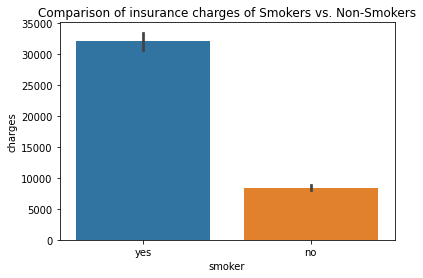

In [14]:
# Visualization 
ax = sns.barplot(data =df , x = df["smoker"], y = df["charges"])
ax.set_title("Comparison of insurance charges of Smokers vs. Non-Smokers");

## Q2. Are men more likely to smoke than women?

Null Hypothesis: Men are not more likely to smoke than women

Alternative Hypothesis: Men are more likely to smoke than women

Will perform Chi-square test 
- target is categorical

Text(0.5, 1.0, 'Smokers by sex')

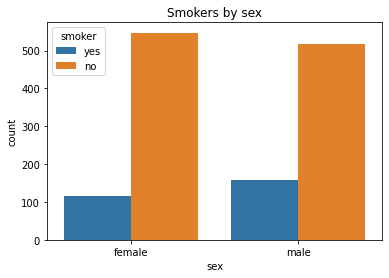

In [15]:
# Plot
ax = sns.countplot(data = df, x = "sex", hue = "smoker")
ax.set_title("Smokers by sex")

In [16]:
# calculate the contingency table
table = pd.crosstab(df["sex"], df["smoker"])
table

smoker,no,yes
sex,,
female,547,115
male,517,159


In [17]:
# # Run test and save output
result = stats.chi2_contingency(table)
chi2, p, deg_free, expected_vals = result

In [18]:
print(p)
p<.05

0.006548143503580696


True

- Since our p-value is less than 0.05 we have a significant result and can reject the null hypothesis.
- We accept the alternate hypothesis and conclude that men are more likely to smoke than women 

## Q3. Do different regions have different charges, on average?

Null Hypothesis - Different regions to not have a difference in charges on average

Alternate Hypothesis - Different regions do have a difference in charges on average 


Text(0.5, 1.0, 'Charges Based on Region ')

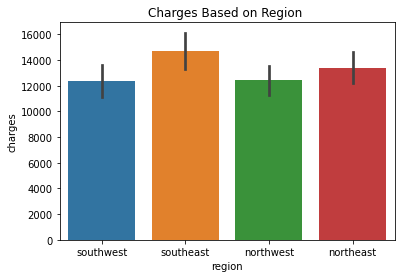

In [19]:
# Visualize 
ax = sns.barplot(data = df, x = "region", y = "charges")
ax.set_title("Charges Based on Region ")

In [20]:
# Create groups dict
groups = {}
# Loop 
for i in df["region"].unique():
    # get series for group and rename
    data = df.loc[df["region"]==i, "charges"].copy()
    
    # save into dict
    groups[i] = data
groups.keys()

dict_keys(['southwest', 'southeast', 'northwest', 'northeast'])

In [21]:
# Normality test of each group and confirming there is greater than 15 in each group 
norm_results = {}
for i, data in groups.items():
    stat, p = stats.normaltest(data)
    # save pval, test stat, and size of group 
    norm_results[i] = {"n":len(data),
                      "p":p,
                      "test_stat":stat,}
# convert to df
norm_results_df = pd.DataFrame(norm_results).T
norm_results_df

,n,p,test_stat
southwest,325.0,6.125298e-23,102.294059
southeast,364.0,4.953297e-15,65.877446
northwest,325.0,5.184209e-24,107.232850
northeast,324.0,1.455431e-19,86.747629


- Groups don't have normal distribution but we can ignore due to having a sample size > 15

In [22]:
# Testing assumption equal variance
stats.levene(*groups.values())

LeveneResult(statistic=5.559966758410606, pvalue=0.0008610590250786703)

- p-value is < 0.05 therefore our groups do not have equal variance

Will perform a Kruskal Wallis Test 
- Target is numeric and has more than 2 samples
- Observations are independent 
- Doesnt have normality 

In [28]:
# Perform test
results = stats.kruskal(*groups.values())
results

KruskalResult(statistic=4.734181215658743, pvalue=0.19232908072121002)

- p-value is > 0.05 therefore we accept our null hypothesis and conclude that different regions do not have a significant difference in charges. 